In [137]:
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [139]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load Data

In [140]:
df = pd.read_csv("gaze_labels.csv", index_col = "Participant_ID")

In [141]:
df.head()

,PHQ_Score,PHQ_Binary
Participant_ID,,
300,2,0
301,3,0
302,4,0
303,0,0
304,6,0


In [142]:
X = np.load("avg_gaze.npy")
y = df['PHQ_Binary']

# Visualizing data

In [7]:
# separate depressed and non-depressed samples to plot
dep = []
non_dep = []
for i in range(y_train.shape[0]):
    if y_train[i] == 1:
        dep.append(X_train[i])
    else:
        non_dep.append(X_train[i])
dep = np.array(dep)
non_dep = np.array(non_dep)

NameError: name 'y_train' is not defined

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(111, projection='3d')

xd = dep[:,0]
yd = dep[:,1]
zd = dep[:,2]
ax0.scatter(xd, yd, zd, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,0]
yn = non_dep[:,1]
zn = non_dep[:,2]
ax0.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


ax0.set_xlabel('x0')
ax0.set_ylabel('y0')
ax0.set_zlabel('z0')

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')

xd = dep[:,3]
yd = dep[:,4]
zd = dep[:,5]
ax1.scatter(xd, yd, zd, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,3]
yn = non_dep[:,4]
zn = non_dep[:,5]
ax1.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax1.set_zlabel('z1')

In [ ]:
plt.scatter(xd, zd, label='depressed')
plt.scatter(xn, zn, label='non-depressed')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
axh0 = fig.add_subplot(111, projection='3d')

xd = dep[:,6]
yd = dep[:,7]
zd = dep[:,8]
axh0.scatter(xd, yd, zd, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,6]
yn = non_dep[:,7]
zn = non_dep[:,8]
axh0.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


axh0.set_xlabel('x_h0')
axh0.set_ylabel('y_h0')
axh0.set_zlabel('z_h0')

In [ ]:
plt.scatter(yd, zd, label='depressed')
plt.scatter(yn, zn, label='non-depressed')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
axh1 = fig.add_subplot(111, projection='3d')

xd = dep[:,9]
yd = dep[:,10]
zd = dep[:,11]
axh1.scatter(xd, yd, zd, s=50, alpha=0.6, edgecolors='w')

xn = non_dep[:,9]
yn = non_dep[:,10]
zn = non_dep[:,11]
axh1.scatter(xn, yn, zn, s=50, alpha=0.6, edgecolors='w')


axh1.set_xlabel('x_h1')
axh1.set_ylabel('y_h1')
axh1.set_zlabel('z_h1')

In [ ]:
plt.scatter(xd, yd, label='depressed')
plt.scatter(xn, yn, label='non-depressed')
plt.legend()
plt.show()

# Prepare data

In [143]:
X_f0 = X[:,0:3]
X_f1 = X[:,3:6]
X_fh0 = X[:,6:9]
X_fh1 = X[:,9:12]
X_f01 = X[:,0:6]
X_fh0h1 = X[:,6:12]

In [144]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [145]:
X_train, X_test, y_train, y_test = train_test(X_f01, y, '../test_split_Depression_AVEC2017.csv')

In [146]:
X_test.shape

(45, 6)

In [147]:
RANDOM_STATE = 42

In [148]:
def undersampling(X_train, y_train):
    random.seed(RANDOM_STATE)
    
    neg_list = [i for i in range(len(y_train)) if y_train[i] == 0]
    pos_list = [i for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_list) < len(pos_list):
        minority_list = neg_list
        majority_list = pos_list
    else:
        minority_list = pos_list
        majority_list = neg_list
        
    sampled_list = random.sample(majority_list, len(minority_list))
    
    final_list = sampled_list + minority_list
    
    X_train_us = []
    y_train_us = []
    
    for i in final_list:
        X_train_us.append(X_train[i])
        y_train_us.append(y_train[i])
                                 
    return np.array(X_train_us), np.array(y_train_us)

X_train, y_train = undersampling(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 6), (45, 6), (82,), (45,))

In [149]:
# np.save("X_train_g01.npy", X_train)
# np.save("X_test_g01.npy", X_test)
# np.save("y_train_g01.npy", y_train)

# Evaluation Metrics

In [14]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

# Testing different models using k-cross

# Neural Network Model

In [1264]:
# n_input = X_train.shape[1]
# n_features = X_train.shape[2]
# input_shape = (n_input, n_features)

In [1265]:
model = Sequential()
# model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(50, input_shape=input_shape))
# model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1266]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
checkpoint_filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [1267]:
model.fit(X_train, y_train, batch_size=16, epochs=30, validation_split=0.1, callbacks=[es, checkpoint])

Train on 122 samples, validate on 14 samples
Epoch 1/30
122/122 [==============================] - 0s 2ms/step - loss: 0.7321 - accuracy: 0.4180 - val_loss: 0.9151 - val_accuracy: 0.0000e+00
Epoch 2/30
122/122 [==============================] - 0s 434us/step - loss: 0.7264 - accuracy: 0.4180 - val_loss: 0.9012 - val_accuracy: 0.0714
Epoch 3/30
122/122 [==============================] - 0s 376us/step - loss: 0.7208 - accuracy: 0.4344 - val_loss: 0.8875 - val_accuracy: 0.0714
Epoch 4/30
122/122 [==============================] - 0s 329us/step - loss: 0.7148 - accuracy: 0.4508 - val_loss: 0.8754 - val_accuracy: 0.1429
Epoch 5/30
122/122 [==============================] - 0s 327us/step - loss: 0.7101 - accuracy: 0.4754 - val_loss: 0.8628 - val_accuracy: 0.1429
Epoch 6/30
122/122 [==============================] - 0s 294us/step - loss: 0.7054 - accuracy: 0.5000 - val_loss: 0.8507 - val_accuracy: 0.2143
Epoch 7/30
122/122 [==============================] - 0s 309us/step - loss: 0.7003 - accu

In [1268]:
model = load_model(checkpoint_filepath)

[0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 1 1 0 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0] 

AUC is:  0.5138248847926267
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        31
           1       0.33      0.29      0.31        14

    accuracy                           0.60        45
   macro avg       0.52      0.51      0.51        45
weighted avg       0.58      0.60      0.59        45

Confusion Matrix: 
 [[23  8]
 [10  4]]


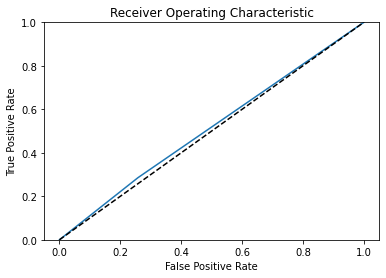

In [1269]:
predictions = model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test, '\n')

evaluate_on_training_set(y_test, y_pred)

# k cross

In [126]:
def k_cross(input_model, X=X_train, y=y_train, k=4, n=3, random_state=42):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = clone(input_model)
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

# Evaluation

In [127]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)
    print(y_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Logistic Regression

In [150]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
            
    print("F1 score:", best_f1)
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.0 > best f1 = -1
power: 0: recall = 0.0 > best recall = -1
power: 3: f1 = 0.01041666666666667 > best f1 = 0.0
power: 3: recall = 0.007575757575757576 > best recall = 0.0
F1 score: 0.01041666666666667


[1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 1 1 1 0 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.423963133640553
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        31
           1       0.25      0.43      0.32        14

    accuracy                           0.42        45
   macro avg       0.43      0.42      0.41        45
weighted avg       0.50      0.42      0.44        45

Confusion Matrix: 
 [[13 18]
 [ 8  6]]


LogisticRegression(C=1000, n_jobs=3)

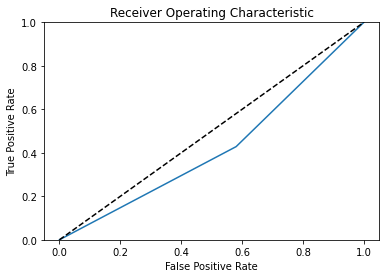

In [151]:
# Based on f1
evaluate_model(best_logreg_f1_model)

# Decision Tree

In [152]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
                print("F1: ",f1)
                print("Recall: ", recall)
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
                
            
    print("F1 score:", best_f1)
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.06212606837606838 > best f1 = -1
F1:  0.06212606837606838
Recall:  0.04648245273245274
depth: 1, leaf: 1: recall = 0.04648245273245274 > best recall = -1
depth: 1, leaf: 6: f1 = 0.08434829059829059 > best f1 = 0.06212606837606838
F1:  0.08434829059829059
Recall:  0.06500097125097125
depth: 1, leaf: 6: recall = 0.06500097125097125 > best recall = 0.04648245273245274
depth: 1, leaf: 10: f1 = 0.09337606837606838 > best f1 = 0.08434829059829059
F1:  0.09337606837606838
Recall:  0.07426023051023051
depth: 1, leaf: 10: recall = 0.07426023051023051 > best recall = 0.06500097125097125
depth: 2, leaf: 6: f1 = 0.11064814814814815 > best f1 = 0.09337606837606838
F1:  0.11064814814814815
Recall:  0.08761493136493137
depth: 2, leaf: 6: recall = 0.08761493136493137 > best recall = 0.07426023051023051
depth: 2, leaf: 10: f1 = 0.14372964997965 > best f1 = 0.11064814814814815
F1:  0.14372964997965
Recall:  0.12528328153328153
depth: 2, leaf: 10: recall = 0.12528328153328153 > 

[1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 1 1 0 1 0 1 0 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.49884792626728114
              precision    recall  f1-score   support

           0       0.69      0.35      0.47        31
           1       0.31      0.64      0.42        14

    accuracy                           0.44        45
   macro avg       0.50      0.50      0.44        45
weighted avg       0.57      0.44      0.45        45

Confusion Matrix: 
 [[11 20]
 [ 5  9]]


DecisionTreeClassifier(max_depth=13, random_state=42)

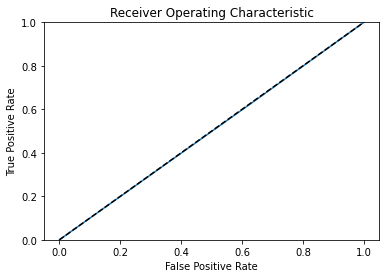

In [153]:
# Based on f1
evaluate_model(best_tree_f1_model)

[1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 1 1 0 1 0 1 0 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.49884792626728114
              precision    recall  f1-score   support

           0       0.69      0.35      0.47        31
           1       0.31      0.64      0.42        14

    accuracy                           0.44        45
   macro avg       0.50      0.50      0.44        45
weighted avg       0.57      0.44      0.45        45

Confusion Matrix: 
 [[11 20]
 [ 5  9]]


DecisionTreeClassifier(max_depth=13, random_state=42)

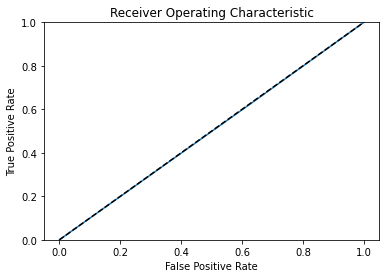

In [154]:
# Based on recall
evaluate_model(best_tree_recall_model)

# RF

In [155]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    print("F1 score:", best_f1)
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.253076905226028 > best f1 = -1
estimator: 1: recall = 0.24718337218337214 > best recall = -1
F1 score: 0.253076905226028


[1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0
 1 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5564516129032259
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        31
           1       0.37      0.50      0.42        14

    accuracy                           0.58        45
   macro avg       0.55      0.56      0.55        45
weighted avg       0.62      0.58      0.59        45

Confusion Matrix: 
 [[19 12]
 [ 7  7]]


RandomForestClassifier(n_estimators=1, random_state=42)

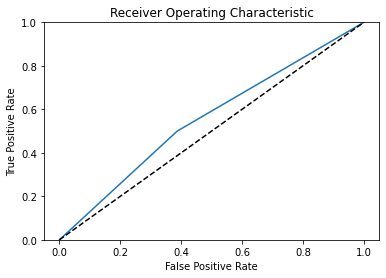

In [156]:
# Based on f1
evaluate_model(best_forest_f1_model)

[1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0
 1 0 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5564516129032259
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        31
           1       0.37      0.50      0.42        14

    accuracy                           0.58        45
   macro avg       0.55      0.56      0.55        45
weighted avg       0.62      0.58      0.59        45

Confusion Matrix: 
 [[19 12]
 [ 7  7]]


RandomForestClassifier(n_estimators=1, random_state=42)

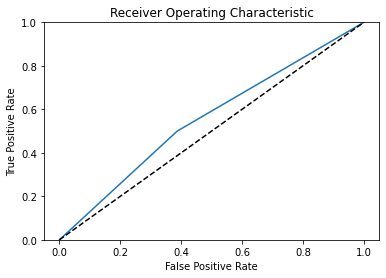

In [157]:
# Based on recall
evaluate_model(best_forest_recall_model)

# SVM with Grid Search

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


f1 mean score: 0.07430555555555556
recall mean score: 0.05165436415436416
Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.9s finished


[0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.4135944700460829
              precision    recall  f1-score   support

           0       0.63      0.61      0.62        31
           1       0.20      0.21      0.21        14

    accuracy                           0.49        45
   macro avg       0.42      0.41      0.41        45
weighted avg       0.50      0.49      0.49        45

Confusion Matrix: 
 [[19 12]
 [11  3]]
Best SVM parameters: {'C': 100, 'degree': 3, 'kernel': 'poly'}


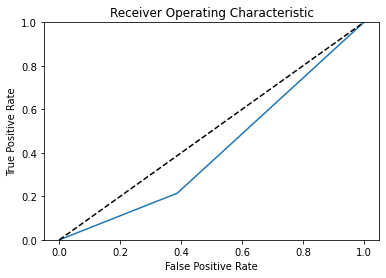

In [158]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5, 6, 7], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000, 10000, 100000]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)
print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")